<a id="top_section"></a>
<div align='center'><font size="6" color="#000000"><b>Descartes Underwriting Test</b></font></div>
<hr>
<div align='center'><font size="4" color="#000000">Auto Insurance - Predict the expected loss for claims</font></div>
<hr>

**Name**: NGUYEN Thanh-Long

**Email**: nguyenthanhlong1990@gmail.com

# Table of Contents
* [Problem Statement and Solutions](#Problem_Statement)
* [Packages install and import](#package)
* [Read and Explore Data](#Read_and_explore_data)
  * [EDA](#eda)
  * [Missing value check](#missing_check)
* [Model Pipeline](#Model_Pipeline)
* [Submission](#Submission)

<a id="Problem_Statement"></a>
# Problem Statement and Solutions 

## Problem Statement
The purpose of this notebook is to make a prediction on the dataset Auto Insurance available on [https://www.kaggle.com/c/auto-insurance-fall-2017/data](https://www.kaggle.com/c/auto-insurance-fall-2017/data) of target **TARGET_FLAG**

## Findings and Solutions:
* This notebook has focused on the below issues of the dataset:
  - Imbalanced Binary Classification.
  - Solving Data Leakage via Cross-Validation
  - Training pipeline
  - Hyperparameter optimization
  - Model training and prediction
* Full Model Training pipeline:
  - Missing values imputation on numerical and categorical features.
  - WOE Encoding for categorical features.
  - SMOTE technique for Imbalanced Classification
  - Stratified K-Folds Cross-Validation
  - GridSearchCV on different classifers and picked out the best perform ones. 
  - Trained models (Random Forest, Decision Tree, Logistic Regression) will be stored in list as it could be reused within the notebook or model export for future uses.
* Some factors should be considered as the model should minimize the false positives or false negatives. However, due to the dataset's lack of information, the F1 macro score will be the primary comparison metric as it would be suitable for the imbalanced binary classification problem. 

## Further Discussion:
- This notebook could be expanded with other ensemble learning methods such as Voting, Bagging, Boosting and Stacking Classifiers - refer to my kaggle notebook about this issue [Bank Marketing: Ensemble Learning Pipeline](https://www.kaggle.com/longtng/bank-marketing-ensemble-learning-pipeline/)
- Furthermore, as it was built up in a modular pipeline, which could be expanded for further different experiments such as other Categorical Encoders, Sampling techniques, or various hyperparameter optimizations such as Random search, Bayesian, etc.
- Another factor could be considered as the measure of feature importances via [SHAP package](https://github.com/slundberg/shap).

---

<a id="package"></a>

# Packages install and import
[Back To Table of Contents](#top_section)

In [1]:
# Package install 
!pip install -q category_encoders==2.2.2
!pip install -q feature_engine==1.0.2
!pip install -q ipython-autotime
%load_ext autotime

time: 2.04 ms (started: 2021-03-18 22:56:13 +00:00)


In [2]:
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
# some setting for visualization output
import matplotlib.pyplot as plt; 
plt.style.use('fivethirtyeight')
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
import seaborn as sns
sns.set_context('notebook')

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import category_encoders
from category_encoders import WOEEncoder

import feature_engine
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer

time: 541 ms (started: 2021-03-18 22:56:13 +00:00)


In [3]:
# print out the python and all the packages' version, which have been used in this notebook 
print("Python and packages versions:")
print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("seaborn version: ", sns.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("skearn version:", sklearn.__version__)
print("imblearn version:", imblearn.__version__)
print("category_encoders version:", category_encoders.__version__)
print("feature_engine version:", feature_engine.__version__)

Python and packages versions:
Python version: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Version info.: sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)
pandas version: 1.1.5
numpy version: 1.19.5
seaborn version:  0.11.1
matplotlib version:  3.2.2
skearn version: 0.22.2.post1
imblearn version: 0.4.3
category_encoders version: 2.2.2
feature_engine version: 1.0.2
time: 9.3 ms (started: 2021-03-18 22:56:13 +00:00)


<a id="Read_and_explore_data"></a>

# Read and Explore Data
[Back To Table of Contents](#top_section)

In [4]:
# read the input data
link_train = "https://raw.githubusercontent.com/longtng/Descartes-Underwriting-Test/main/auto-insurance-fall-2017/train_auto.csv"
link_test = "https://raw.githubusercontent.com/longtng/Descartes-Underwriting-Test/main/auto-insurance-fall-2017/test_auto.csv"

df_train = pd.read_csv(link_train).drop(columns=["INDEX", "TARGET_AMT"])
df_test = pd.read_csv(link_test).drop(columns=["TARGET_FLAG", "TARGET_AMT"])
display(df_train.shape, df_test.shape)
display(df_train.head().T)
display(df_train.info())

(8161, 24)

(2141, 24)

,0,1,2,3,4
TARGET_FLAG,0,0,0,0,0
KIDSDRIV,0,0,0,0,0
AGE,60,43,35,51,50
HOMEKIDS,0,0,1,0,0
YOJ,11,11,10,14,NaN
INCOME,"$67,349","$91,449","$16,039",NaN,"$114,986"
PARENT1,No,No,No,No,No
HOME_VAL,$0,"$257,252","$124,191","$306,251","$243,925"
MSTATUS,z_No,z_No,Yes,Yes,Yes
SEX,M,M,z_F,M,z_F


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   object 
 6   PARENT1      8161 non-null   object 
 7   HOME_VAL     7697 non-null   object 
 8   MSTATUS      8161 non-null   object 
 9   SEX          8161 non-null   object 
 10  EDUCATION    8161 non-null   object 
 11  JOB          7635 non-null   object 
 12  TRAVTIME     8161 non-null   int64  
 13  CAR_USE      8161 non-null   object 
 14  BLUEBOOK     8161 non-null   object 
 15  TIF          8161 non-null   int64  
 16  CAR_TYPE     8161 non-null   object 
 17  RED_CAR      8161 non-null   object 
 18  OLDCLAIM     8161 non-null   object 
 19  CLM_FR

None

time: 363 ms (started: 2021-03-18 22:56:14 +00:00)


In [5]:
# Convert currency columns from string to numercial values
currency_cols = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]
df_train[currency_cols] = df_train[currency_cols].replace('[\$,]', '', regex=True).astype(float)
df_test[currency_cols] = df_test[currency_cols].replace('[\$,]', '', regex=True).astype(float)

time: 96.6 ms (started: 2021-03-18 22:56:14 +00:00)


In [6]:
# Check and drop duplicated values 
df_train.drop_duplicates(inplace=True) 
df_train.shape

(8161, 24)

time: 29.3 ms (started: 2021-03-18 22:56:14 +00:00)


In [7]:
# Select out the numerical and categorical features
df_num = df_train.drop(['TARGET_FLAG'], axis=1).select_dtypes(include=[np.dtype('int64'), np.dtype('float64')])
df_cat = df_train.select_dtypes(include=[np.dtype('object')])
num_cols, cat_cols = df_num.columns.tolist(), df_cat.columns.tolist()

print(f"Numerical columns: {num_cols}.")
print(f"Categorical columns: {cat_cols}.")
# print(cat_cols)

Numerical columns: ['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS', 'CAR_AGE'].
Categorical columns: ['PARENT1', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY'].
time: 20.8 ms (started: 2021-03-18 22:56:14 +00:00)


We have a quick look on the unique values of the categorical and numerical features  

In [8]:
pd.set_option('display.max_colwidth', 500) # Setting pandas to display a N number of columns

display(pd.DataFrame(df_cat.apply(lambda col: col.sort_values(ascending=True).unique())))
display(pd.DataFrame(df_num.apply(lambda col: col.sort_values(ascending=True).unique())))

,0
PARENT1,"[No, Yes]"
MSTATUS,"[Yes, z_No]"
SEX,"[M, z_F]"
EDUCATION,"[<High School, Bachelors, Masters, PhD, z_High School]"
JOB,"[Clerical, Doctor, Home Maker, Lawyer, Manager, Professional, Student, z_Blue Collar, nan]"
CAR_USE,"[Commercial, Private]"
CAR_TYPE,"[Minivan, Panel Truck, Pickup, Sports Car, Van, z_SUV]"
RED_CAR,"[no, yes]"
REVOKED,"[No, Yes]"
URBANICITY,"[Highly Urban/ Urban, z_Highly Rural/ Rural]"


,0
KIDSDRIV,"[0, 1, 2, 3, 4]"
AGE,"[16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 72.0, 73.0, 76.0, 80.0, 81.0, nan]"
HOMEKIDS,"[0, 1, 2, 3, 4, 5]"
YOJ,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 23.0, nan]"
INCOME,"[0.0, 5.0, 7.0, 18.0, 70.0, 77.0, 130.0, 138.0, 158.0, 195.0, 218.0, 249.0, 263.0, 278.0, 300.0, 312.0, 360.0, 367.0, 381.0, 393.0, 408.0, 419.0, 445.0, 455.0, 479.0, 525.0, 556.0, 571.0, 591.0, 601.0, 605.0, 636.0, 654.0, 666.0, 683.0, 687.0, 727.0, 730.0, 747.0, 776.0, 803.0, 880.0, 907.0, 956.0, 989.0, 997.0, 1007.0, 1022.0, 1102.0, 1114.0, 1133.0, 1158.0, 1201.0, 1212.0, 1249.0, 1336.0, 1344.0, 1405.0, 1423.0, 1463.0, 1545.0, 1573.0, 1590.0, 1613.0, 1702.0, 1719.0, 1729.0, 1754.0, 1764.0..."
HOME_VAL,"[0.0, 50223.0, 50343.0, 50964.0, 51038.0, 51401.0, 51796.0, 51893.0, 52557.0, 52929.0, 52952.0, 53204.0, 53476.0, 53636.0, 54130.0, 54880.0, 55078.0, 55203.0, 55632.0, 55761.0, 55922.0, 56000.0, 56089.0, 56355.0, 56589.0, 57657.0, 58318.0, 58365.0, 58632.0, 58710.0, 58946.0, 59185.0, 59496.0, 59722.0, 59860.0, 60073.0, 60179.0, 60715.0, 60718.0, 60733.0, 60944.0, 60950.0, 61306.0, 61482.0, 61630.0, 62607.0, 62643.0, 63103.0, 63142.0, 63705.0, 63827.0, 64066.0, 64184.0, 64192.0, 64198.0, 6453..."
TRAVTIME,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 101, 103, 113, 124, 134, 142]"
BLUEBOOK,"[1500.0, 1520.0, 1530.0, 1540.0, 1590.0, 1620.0, 1650.0, 1670.0, 1680.0, 1700.0, 1720.0, 1730.0, 1780.0, 1800.0, 1930.0, 1950.0, 2010.0, 2030.0, 2040.0, 2070.0, 2160.0, 2190.0, 2220.0, 2230.0, 2250.0, 2270.0, 2280.0, 2320.0, 2330.0, 2340.0, 2440.0, 2450.0, 2470.0, 2480.0, 2500.0, 2590.0, 2600.0, 2670.0, 2680.0, 2690.0, 2720.0, 2740.0, 2750.0, 2770.0, 2790.0, 2800.0, 2840.0, 2850.0, 2860.0, 2910.0, 2920.0, 2930.0, 2950.0, 2960.0, 3030.0, 3050.0, 3070.0, 3080.0, 3100.0, 3150.0, 3170.0, 3180.0,..."
TIF,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25]"
OLDCLAIM,"[0.0, 502.0, 506.0, 518.0, 519.0, 521.0, 536.0, 537.0, 548.0, 551.0, 555.0, 557.0, 558.0, 565.0, 569.0, 575.0, 582.0, 588.0, 589.0, 592.0, 597.0, 607.0, 610.0, 613.0, 621.0, 633.0, 642.0, 651.0, 652.0, 654.0, 663.0, 677.0, 678.0, 679.0, 683.0, 696.0, 698.0, 702.0, 712.0, 716.0, 718.0, 720.0, 722.0, 725.0, 734.0, 743.0, 746.0, 754.0, 759.0, 763.0, 764.0, 778.0, 785.0, 792.0, 793.0, 795.0, 803.0, 805.0, 808.0, 812.0, 846.0, 856.0, 858.0, 865.0, 867.0, 873.0, 883.0, 893.0, 898.0, 900.0, 922.0, ..."


time: 123 ms (started: 2021-03-18 22:56:14 +00:00)


<a id="eda"></a>

## EDA
[Back To Table of Contents](#top_section)

We will explore the distribution of (imbalanced) **TARGET_FLAG**, the categorical and numerical features

count    8161.000000
mean        0.263816
std         0.440728
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: TARGET_FLAG, dtype: float64


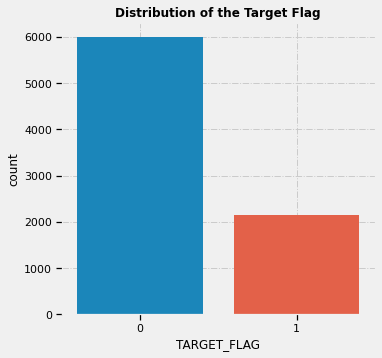

time: 147 ms (started: 2021-03-18 22:56:14 +00:00)


In [9]:
print(df_train["TARGET_FLAG"].describe())

plt.figure(figsize=(5, 5))
sns.countplot(df_train["TARGET_FLAG"]) 
plt.grid(True, linestyle='-.') 
plt.title("Distribution of the Target Flag", weight="semibold") 
plt.show()

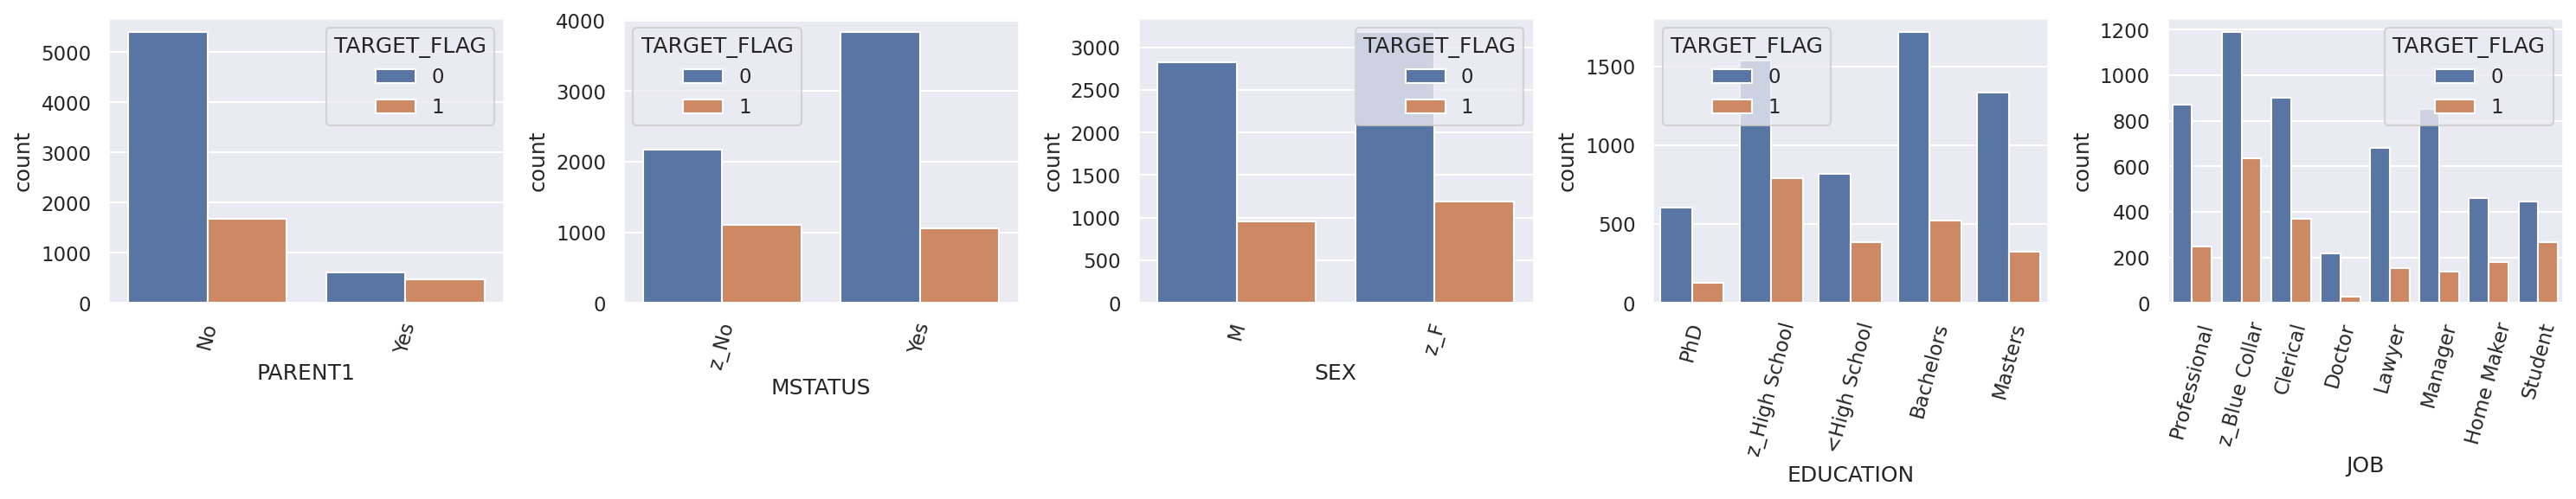

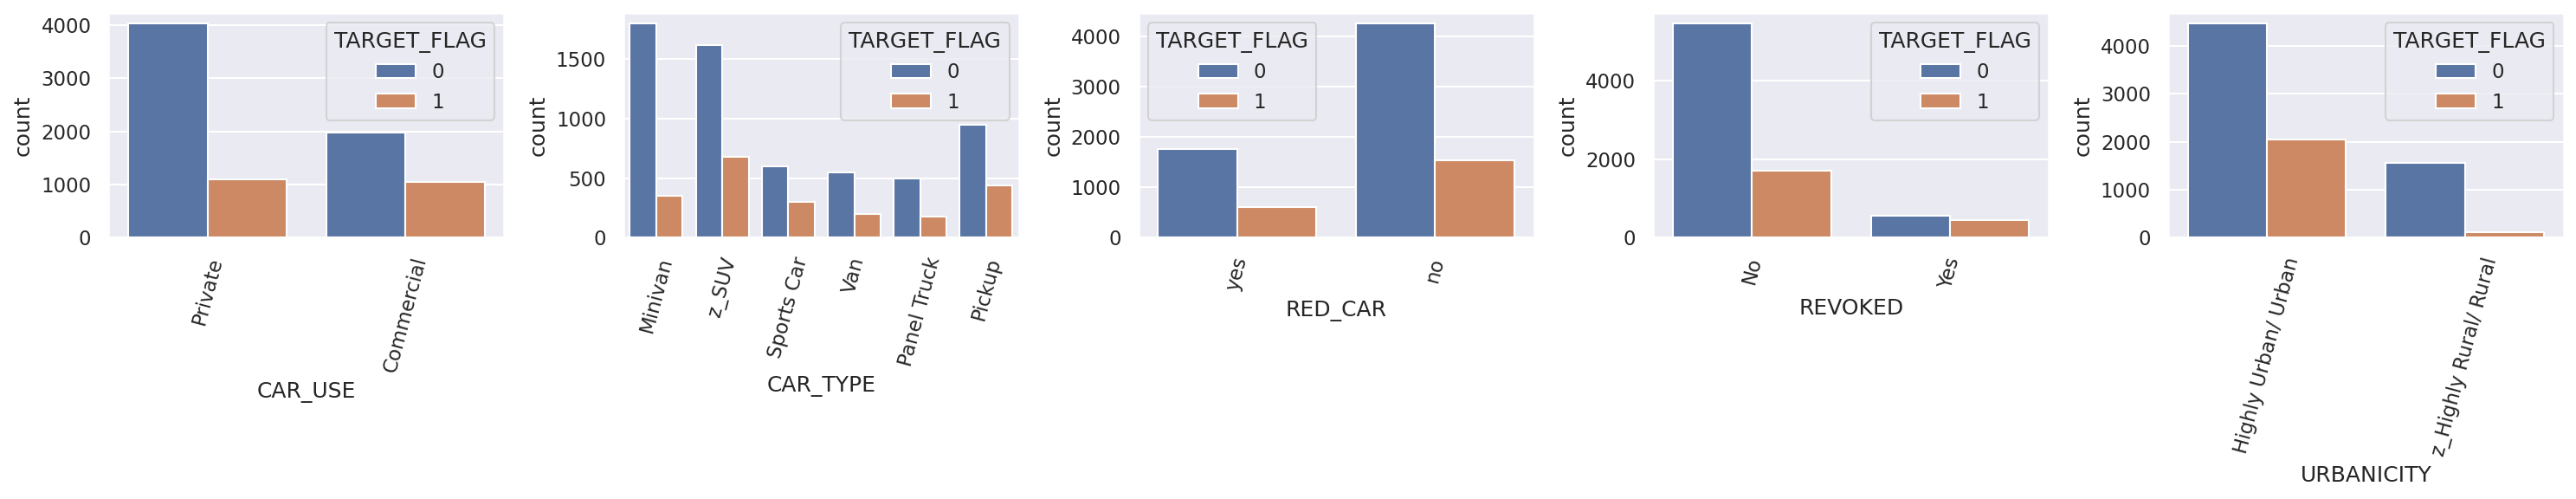

time: 2.79 s (started: 2021-03-18 22:56:14 +00:00)


In [10]:
# Plot the distribbution of categorical attributes
def chunks(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]

def cat_plot(df, cols, target, ncols):
    for lst in chunks(cols, ncols):
        sns.set(font_scale = 1)
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 4), dpi=150)
        for idx in range(0, len(lst)):
            attr = lst[idx]
            data = df[[attr, target]]
            g = sns.countplot(x=attr, data=df, hue=target, ax=axes[idx])
            for item in g.get_xticklabels():
                item.set_rotation(75)
        plt.tight_layout()

cat_plot(df=df_train, cols=cat_cols, target="TARGET_FLAG", ncols=5)

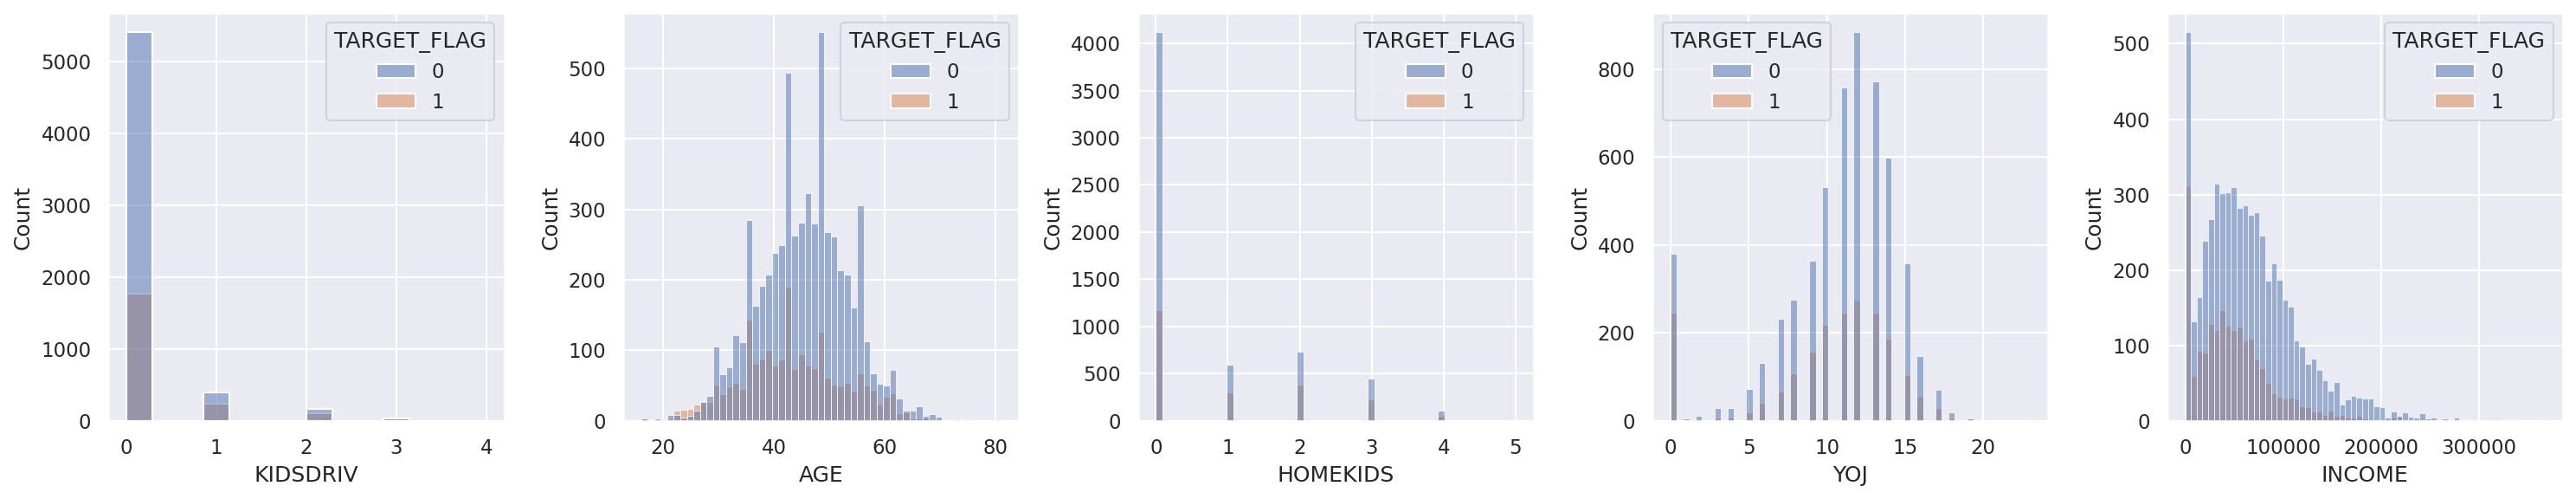

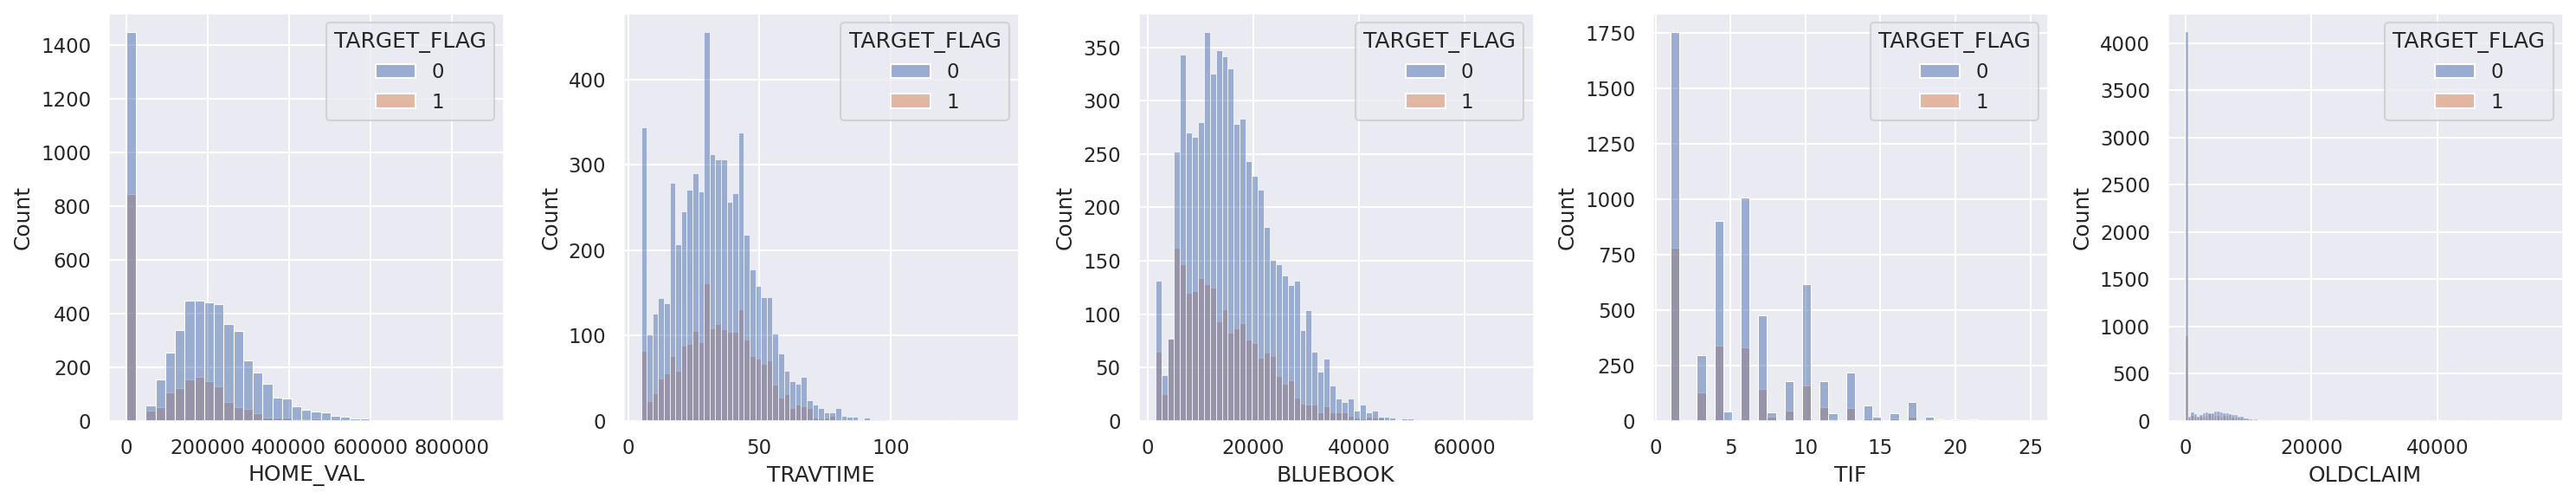

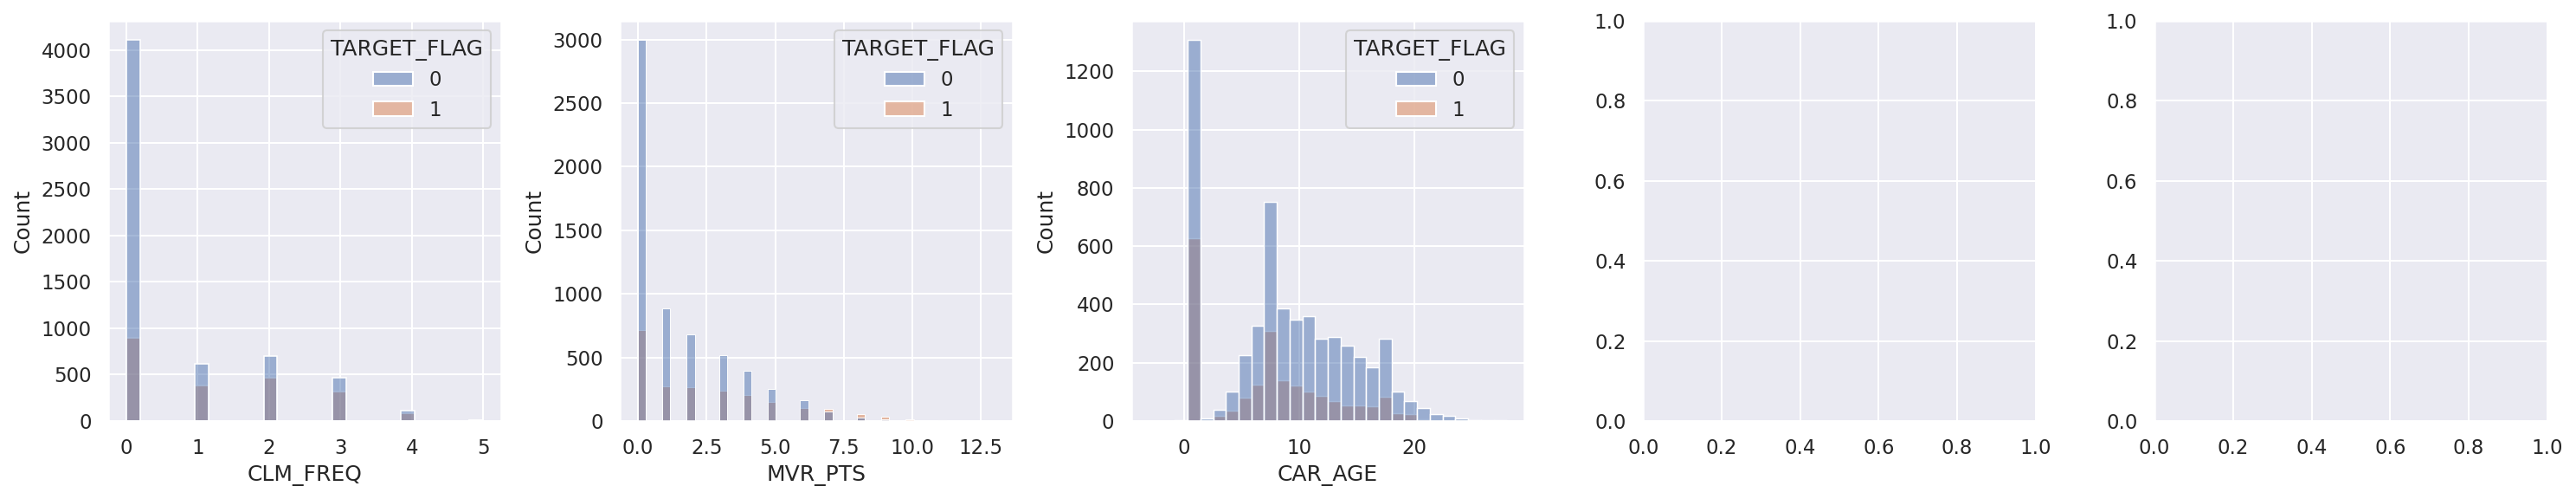

time: 9.76 s (started: 2021-03-18 22:56:17 +00:00)


In [11]:
# Plot the distribbution of numerical attributes    
def chunks(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]

def num_plot(df, cols, target, ncols):
    for lst in chunks(cols, ncols):
        sns.set(font_scale = 1)
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 4), dpi=150)
        for idx in range(0, len(lst)):
            attr = lst[idx]
            data = df[[attr, target]]
            g = sns.histplot(x=attr, data=data.dropna(), hue=target, ax=axes[idx], kde_kws={'bw': 1.5})
        plt.tight_layout()

num_plot(df=df_train, cols=num_cols, target="TARGET_FLAG", ncols=5)

## Comments:
- The distribution of **TARGET_FLAG** is imbalanced, apperently, this is a imbalanced classification problem.
- The **TARGET_FLAG** also distributed similarly accross all the features. 

<a id="missing_check"></a>

## Missing value check
[Back To Table of Contents](#top_section)

In [12]:
def missingcheck(df):
  """
    Calculate the missing values in each attribute
    The results are the total numbers of attributes having missing values and 
    percentages of non-missing values of these attribute
  """
  total = df.isnull().sum()
  percent = (df.isnull().sum()/df.isnull().count()*100)
  missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  total_missing = df_train.shape[0] - df_train.dropna().shape[0]
  missing.loc["Total Missing"] = [total_missing, (total_missing)/df_train.shape[0]*100]
  missing = missing[missing['Total']>0]
  missing = missing.sort_values(by=['Percent'], ascending=False)
  print("The attributes having missing values and percentages of non-missing values of these attributes:")
  print()
  print(missing)
  print()
  print("The number of attributes have missing values are", len(missing)-1)
  return missing

time: 11.6 ms (started: 2021-03-18 22:56:27 +00:00)


In [13]:
# List out all the Missing Values:
missing = missingcheck(df_train)
missing = missing.drop("Total Missing")

The attributes having missing values and percentages of non-missing values of these attributes:

                Total    Percent
Total Missing  2116.0  25.928195
JOB             526.0   6.445289
CAR_AGE         510.0   6.249234
HOME_VAL        464.0   5.685578
YOJ             454.0   5.563044
INCOME          445.0   5.452763
AGE               6.0   0.073520

The number of attributes have missing values are 6
time: 53.4 ms (started: 2021-03-18 22:56:27 +00:00)


In [14]:
# List out all the Missing Values:
missing = missingcheck(df_test)
missing = missing.drop("Total Missing")

The attributes having missing values and percentages of non-missing values of these attributes:

                Total    Percent
Total Missing  2116.0  25.928195
JOB             139.0   6.492293
CAR_AGE         129.0   6.025222
INCOME          125.0   5.838393
HOME_VAL        111.0   5.184493
YOJ              94.0   4.390472
AGE               1.0   0.046707

The number of attributes have missing values are 6
time: 29.1 ms (started: 2021-03-18 22:56:27 +00:00)


## Comment
- Both train and test set have same missing value features. 
- We got ~26% of missing values, missing value could be imputed with different methods case-by-case. However, due to the limitation of time, we will filled up the missing values with following strategies:
  - Numerical case: mean values of the whole feature - could be expand after digging deep on the distribution of each feature.
  - Categorical case: consider the missing value as "missing" category. 

<a id="Model_Pipeline"></a>
# Model Pipeline
[Back To Table of Contents](#top_section)

In [15]:
TEST_SIZE = 0.3
RAND = 42

X_temp = df_train.drop(["TARGET_FLAG"], axis=1)
y_temp = df_train["TARGET_FLAG"]
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(["TARGET_FLAG"], axis=1),
                                                  df_train["TARGET_FLAG"], 
                                                  test_size = TEST_SIZE, 
                                                  random_state=RAND)
display(X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_train.head())

(5712, 23)

(2449, 23)

(5712,)

(2449,)

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
2045,0,51.0,0,13.0,81987.0,No,258282.0,z_No,M,z_High School,z_Blue Collar,36,Private,14800.0,9,Minivan,no,0.0,0,No,0,8.0,z_Highly Rural/ Rural
6636,0,73.0,0,15.0,1773.0,No,0.0,z_No,z_F,Bachelors,Student,46,Private,8980.0,7,Sports Car,no,0.0,0,No,1,14.0,Highly Urban/ Urban
462,1,38.0,2,13.0,15755.0,No,112616.0,Yes,z_F,<High School,z_Blue Collar,32,Commercial,14440.0,4,Minivan,no,1413.0,1,No,0,1.0,z_Highly Rural/ Rural
1956,1,38.0,2,12.0,10287.0,Yes,NaN,z_No,M,<High School,z_Blue Collar,11,Commercial,19320.0,7,Van,no,0.0,0,No,0,1.0,z_Highly Rural/ Rural
2445,0,60.0,0,13.0,99441.0,No,0.0,z_No,M,PhD,NaN,51,Commercial,28560.0,7,Panel Truck,yes,0.0,0,No,0,13.0,Highly Urban/ Urban


time: 74.6 ms (started: 2021-03-18 22:56:27 +00:00)


In [16]:
def batch_classify(X_train, Y_train, X_val, Y_val, dict_classifiers):
    """
    This function take input data and list of classifiers with hyperparameters. 
    The output is the comparison of models' metrics and sorted based on F1 score
    And store the trained models - which could be reused later or export to file for further uses. 
    """
    
    # Create the comparison table - using for comparing between trained models
    comp_models = pd.DataFrame(columns = ["classifiers", "train_roc_auc", "val_roc_auc", 
                                          "train_f1", "val_f1"])
    
    # dictionary the save trained models
    dict_models = {}

    for classifier_name, classifier in list(dict_classifiers.items()):      
        # Model pipeline: impute the numerical/ categorical features -> WOEEncoder the categorical features -> SMOTE -> model
        imba_pipeline = Pipeline([("Impute_num", MeanMedianImputer(imputation_method="mean", variables=num_cols)), 
                                  ("Impute_cat", CategoricalImputer(imputation_method="missing", 
                                                                    fill_value="Other", variables=cat_cols)),
                                  ("WOEEncoder", WOEEncoder(cols = cat_cols)),
                                  ("SMOTE", SMOTE(random_state=RAND, n_jobs=-1)), 
                                  ("model", classifier["model"])
                                ])
                
        # Stratified K-Folds Cross-Validation
        skf = StratifiedKFold(n_splits=5, random_state=RAND, shuffle=True)
        
        # GrivSearchCV to find best parameters 
        grid_imba = GridSearchCV(estimator=imba_pipeline, 
                                 param_grid=classifier.get("param_grid"), 
                                 n_jobs=-1, pre_dispatch='2*n_jobs',
                                 cv=skf, scoring="f1_macro", refit="f1_macro", return_train_score=True)
        
        # Fit and predict
        grid_imba.fit(X_train, Y_train)        
        Y_train_preds = grid_imba.predict(X_train)
        Y_val_preds = grid_imba.predict(X_val)

        # Export model
        dict_models[classifier_name] = grid_imba.best_estimator_
        
        # Append the trained model metrics into the comparison table
        comp_models = comp_models.append({"classifiers": classifier_name, 
                                          "train_roc_auc": roc_auc_score(Y_train, Y_train_preds, average='macro'), 
                                          "val_roc_auc": roc_auc_score(Y_val, Y_val_preds, average='macro'), 
                                          "train_f1": f1_score(Y_train, Y_train_preds, average='macro'), 
                                          "val_f1": f1_score(Y_val, Y_val_preds, average='macro')}, 
                                        ignore_index=True)
    
    return dict_models, comp_models.sort_values(by="val_f1", ascending=False).reset_index(drop=True)

time: 32 ms (started: 2021-03-18 22:56:27 +00:00)


In [17]:
# the dict_classifiers stores the model and it hyperparameters
dict_classifiers = {
        "Logistic Regression": {"model": LogisticRegression(random_state=RAND), 
                                "param_grid": {"model__C": [0.3, 0.6]}
                                },
        "Decision Tree": {"model": tree.DecisionTreeClassifier(random_state=RAND), 
                          "param_grid": {"model__max_depth": [16, 18, 20], 
                                         "model__criterion": ["gini", "entropy"]}
                          },
        "Random Forest": {"model": RandomForestClassifier(random_state=RAND, n_jobs=-1), 
                          "param_grid": {"model__n_estimators": [250, 500], 
                                         "model__max_depth": [6, 8]}
                          }
                    }

dict_models, comp_models = batch_classify(X_train, y_train, X_val, y_val, dict_classifiers)
comp_models

,classifiers,train_roc_auc,val_roc_auc,train_f1,val_f1
0,Random Forest,0.772998,0.708584,0.776272,0.715645
1,Decision Tree,0.945134,0.628140,0.944186,0.628518
2,Logistic Regression,0.612366,0.613228,0.574454,0.575490


time: 1min 15s (started: 2021-03-18 22:56:27 +00:00)


In [18]:
print("The highest F1 score model:")
print(dict_models[comp_models["classifiers"][0]])

The highest F1 score model:
Pipeline(memory=None,
         steps=[('Impute_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['KIDSDRIV', 'AGE', 'HOMEKIDS',
                                              'YOJ', 'INCOME', 'HOME_VAL',
                                              'TRAVTIME', 'BLUEBOOK', 'TIF',
                                              'OLDCLAIM', 'CLM_FREQ', 'MVR_PTS',
                                              'CAR_AGE'])),
                ('Impute_cat',
                 CategoricalImputer(fill_value='Other',
                                    imputation_method='missing',
                                    return_object=False,
                                    variables=['PARENT1', 'MSTAT...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=8, max_featur

<a id="Submission"></a>
# Submission
[Back To Table of Contents](#top_section)

In [19]:
# Create the prediction on test set and submission
df_test_predict = dict_models[comp_models["classifiers"][0]].predict(df_test.iloc[:, 1:])

submission = pd.DataFrame(data={'INDEX': df_test["INDEX"].values, 
                                'p_target': df_test_predict})
submission.to_csv("submission.csv")

time: 250 ms (started: 2021-03-18 22:57:43 +00:00)
